# Install spark-related dependencies

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz

!tar xf spark-2.4.5-bin-hadoop2.7.tgz

!pip install -q findspark

!pip install pyspark

     |████████████████████████████████| 217.8MB 60kB/s 
     |████████████████████████████████| 204kB 44.0MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=cf1eafc769dac31e6579276f6d8d55e832deff4da3bd228d50f00f9cd7c808ed
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


#Set up required environment variables

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

#Import Tools and Set Up Spark Context

In [0]:
# Tools we need to connect to the Spark server, load our data,
# clean it and prepare it
from pyspark import SparkContext, SparkConf
import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('recnn').getOrCreate()

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import matplotlib.pyplot as plt
import numpy as np

In [0]:
APP_NAME = "Andrew"
SPARK_URL = "local[*]"
conf = SparkConf().setAppName(APP_NAME).setMaster(SPARK_URL)
sc = SparkContext.getOrCreate(conf)

#Import the Data

In [0]:
#Import the ratings Dataframe
dataFrame = spark.read.csv('ratings.csv')
ratingsDF = pd.read_csv('ratings.csv')
data = sc.textFile('ratings.csv').map(lambda line: line.split(","))
data1 = data.toDF()

#Import the movies Dataframe
moviesDF = pd.read_csv('movies.csv')

#Clean, Tidy, and Prepare the Data

In [0]:
#for ratings
header = data1.filter((data1['_1'] == 'userId') & (data1['_2'] == 'movieId') & (data1['_3'] == 'rating') & (data1['_4'] == 'timestamp'))
restDF = data1.subtract(header)
headerColumn = header.first()
for column in restDF.columns:
    restDF = restDF.withColumnRenamed(column, headerColumn[column])
#restDF.show(truncate=False)
DF1 = restDF
from pyspark.sql.types import DoubleType
DF2 = DF1.withColumn("userId", DF1["userId"].cast(DoubleType()))
DF3 = DF2.withColumn("movieId", DF1["movieId"].cast(DoubleType()))
DF4 = DF3.withColumn("rating", DF1["rating"].cast(DoubleType()))
DF5 = DF4.withColumn("timestamp", DF1["timestamp"].cast(DoubleType()))

# Split the data into training and test data




In [0]:
(training, test) = DF5.randomSplit([0.8, 0.2])

#Build the Model and Evaluate the Error


In [0]:
als = ALS(nonnegative = True, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", implicitPrefs=False)
model = als.fit(training)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("The Root Mean Squared Error= " + str(rmse)) 

The Root Mean Squared Error= 0.8807170387040474


# Generate top 5 movie recommendations for a set of  users

In [149]:
users = DF5.select(als.getUserCol()).distinct().limit(5)
userSubsetRecs = model.recommendForUserSubset(users, 5)
userSubsetRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   496|[[6818, 4.7784505...|
|   596|[[33649, 4.86407]...|
|   305|[[86345, 5.242970...|
|   299|[[3022, 4.955458]...|
|   558|[[5034, 6.2627954...|
+------+--------------------+



In [0]:
userRec = userSubsetRecs.toPandas()
userRec[['Rec1','Rec2','Rec3','Rec4','Rec5']] = pd.DataFrame(userRec.recommendations.tolist(), index= userRec.index)
#merge9 = pd.merge(left= userRec, right= moviesDF , left_on='movieId', right_on='movieId')
#merge9[['Rec1','Rec2','Rec3','Rec4','Rec5']] = pd.DataFrame(merge6.recommendations.tolist(), index= merge6.index)
userRec[['Rec1_Movie','Rec1_Rating']] = pd.DataFrame(userRec.Rec1.tolist(), index= userRec.index)
userRec[['Rec2_Movie','Rec2_Rating']] = pd.DataFrame(userRec.Rec2.tolist(), index= userRec.index)
userRec[['Rec3_Movie','Rec3_Rating']] = pd.DataFrame(userRec.Rec3.tolist(), index= userRec.index)
userRec[['Rec4_Movie','Rec4_Rating']] = pd.DataFrame(userRec.Rec4.tolist(), index= userRec.index)
userRec[['Rec5_Movie','Rec5_Rating']] = pd.DataFrame(userRec.Rec5.tolist(), index= userRec.index)
userRec = pd.DataFrame.drop(userRec, columns=['recommendations','Rec1','Rec2','Rec3','Rec4','Rec5'], axis = 1)





#Plot the findings

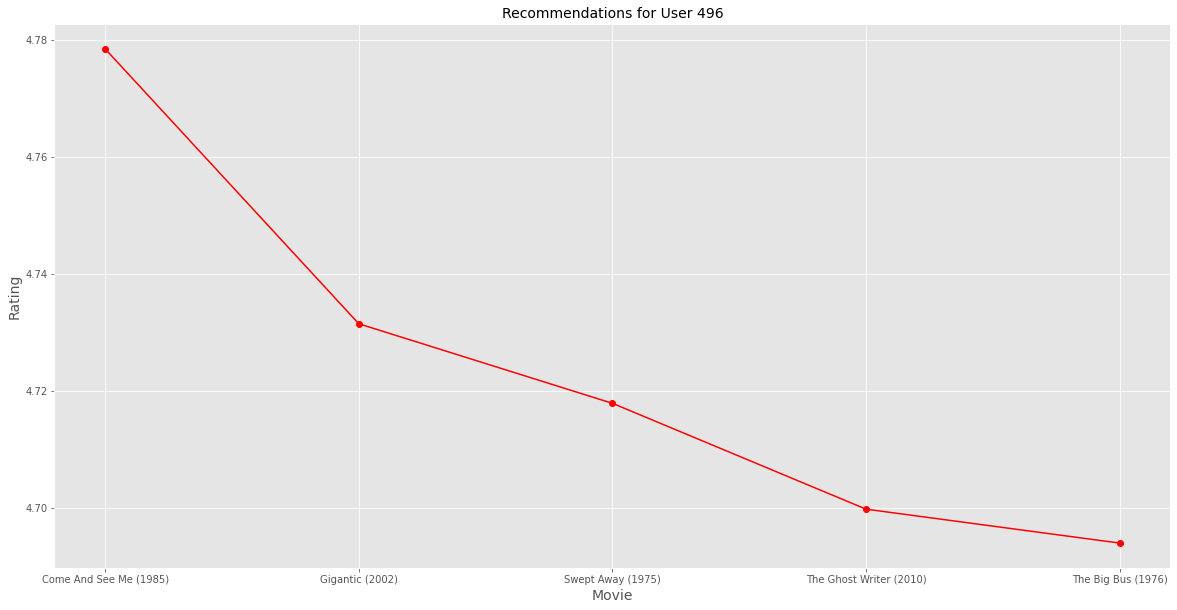

In [147]:
movie_list = ['Come And See Me (1985)', 'Gigantic (2002)', 'Swept Away (1975)', 'The Ghost Writer (2010)', 'The Big Bus (1976)']
ratings496 = [4.7785, 4.7315, 4.7179, 4.6998, 4.6940]

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(movie_list, ratings496, color='red', marker='o')
ax.set_title('Recommendations for User 496', fontsize=14)
ax.set_xlabel('Movie', fontsize=14)
ax.set_ylabel('Rating', fontsize=14)
ax.grid(True)

# Generate top 5 user recommendations for a specified set of movies

In [39]:
movies = DF5.select(als.getItemCol()).distinct().limit(8)
movieSubSetRecs = model.recommendForItemSubset(movies, 5)
movieSubSetRecs.show()

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|    596|[[224, 4.6651483]...|
| 119155|[[53, 4.593817], ...|
| 148675|[[584, 2.2885034]...|
|    299|[[250, 5.052653],...|
|   6765|[[594, 4.5033307]...|
|    558|[[543, 4.6026487]...|
|   3980|[[578, 4.462367],...|
|    934|[[543, 4.7518454]...|
+-------+--------------------+



In [0]:
movieRec = movieSubSetRecs.toPandas()
merge6 = pd.merge(left= movieRec, right= moviesDF , left_on='movieId', right_on='movieId')
merge6[['Rec1','Rec2','Rec3','Rec4','Rec5']] = pd.DataFrame(merge6.recommendations.tolist(), index= merge6.index)
merge6[['Rec1_User','User1_Pred_Rating']] = pd.DataFrame(merge6.Rec1.tolist(), index= merge6.index)
merge6[['Rec2_User','User2_Pred_Rating']] = pd.DataFrame(merge6.Rec2.tolist(), index= merge6.index)
merge6[['Rec3_User','User3_Pred_Rating']] = pd.DataFrame(merge6.Rec3.tolist(), index= merge6.index)
merge6[['Rec4_User','User4_Pred_Rating']] = pd.DataFrame(merge6.Rec4.tolist(), index= merge6.index)
merge6[['Rec5_User','User5_Pred_Rating']] = pd.DataFrame(merge6.Rec5.tolist(), index= merge6.index)
merge6 = pd.DataFrame.drop(merge6, columns=['recommendations','Rec1','Rec2','Rec3','Rec4','Rec5'], axis = 1)



#Plot the Findings

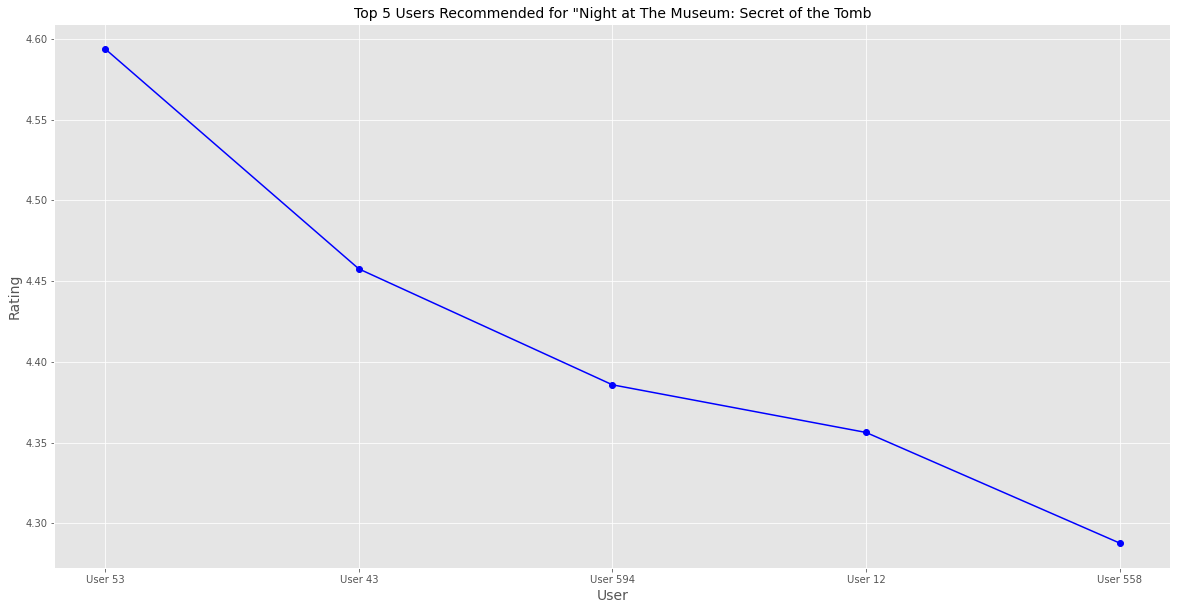

In [142]:
usersG = ['User 53', 'User 43', 'User 594', 'User 12' , 'User 558']
ratingsG = [4.5938, 4.4576, 4.3858, 4.3563, 4.2878]

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(usersG, ratingsG, color='blue', marker='o')
ax.set_title('Top 5 Users Recommended for "Night at The Museum: Secret of the Tomb', fontsize=14)
ax.set_xlabel('User', fontsize=14)
ax.set_ylabel('Rating', fontsize=14)
ax.grid(True)

#Identify Top 5 movie predictions for any user

In [0]:
# definition from https://www.youtube.com/watch?v=FgGjc5oabrA
def get_recs_for_user(recs):
  #Recs should be for a specific user.
  recs = recs.select("recommendations.movieId", "recommendations.rating")
  movies = recs.select("movieId").toPandas().iloc[0,0]
  ratings = recs.select("rating").toPandas().iloc[0,0]
  ratings_matrix = pd.DataFrame(movies,columns=["movieId"])
  ratings_matrix["ratings"] = ratings
  ratings_matrix_ps = sqlContext.createDataFrame(ratings_matrix)
  return ratings_matrix_ps

#Enter a User-Id

In [223]:
# Workaround the Future Warning from https://stackoverflow.com/questions/40659212/futurewarning-elementwise-comparison-failed-returning-scalar-but-in-the-futur
from pyspark.sql import SQLContext
import pyspark.sql.functions as sf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sqlContext = SQLContext(sc)
av1 = 0.0
while True:
    tempav1 = input("Please enter a user Id: ")
    if tempav1.isnumeric() == False:
      print("Error: Please enter a number!")
    else: 
      av1 = float(tempav1)
      dfsubset = DF5.filter(DF5['userId'] == av1)
      if dfsubset.count() == 0: 
        print("Error: That user does not exist. Please enter a valid userId.")
      else:
        print("Thank You")
        dfsubset.show()
        break
print(av1)
#dfsubset = DF5.filter(DF5['userId'] == av1)
userRecs44 = model.recommendForUserSubset(dfsubset, 5)
pie = get_recs_for_user(userRecs44)
pie_df = pie.toPandas()


here: av is 0.0
Please enter a user Id: k
That's not a number!
here: av is 0.0
Please enter a user Id: 615
dropped in else loop:  615.0
That user does not exist. Try again
here: av is 615.0
Please enter a user Id: 305
dropped in else loop:  305.0
Thank You
+------+--------+------+-------------+
|userId| movieId|rating|    timestamp|
+------+--------+------+-------------+
| 305.0|   480.0|   2.0|  1.4902114E9|
| 305.0|106002.0|   4.0|1.460304042E9|
| 305.0|106489.0|   3.0|1.460136597E9|
| 305.0|  6764.0|   3.0|1.535125306E9|
| 305.0| 60514.0|   3.5| 1.46013719E9|
| 305.0|   300.0|   3.5| 1.51819801E9|
| 305.0|   555.0|   5.0|1.460563758E9|
| 305.0|  1466.0|   3.5|1.518767888E9|
| 305.0|  1676.0|   3.5|1.518198046E9|
| 305.0| 48516.0|   4.5|1.460135171E9|
| 305.0|105355.0|   2.5|1.460564044E9|
| 305.0|  2006.0|   5.0|1.461945079E9|
| 305.0|  4896.0|   3.0|1.518198357E9|
| 305.0| 26249.0|   5.0|1.519639479E9|
| 305.0|106100.0|   4.5|1.460135606E9|
| 305.0|   541.0|   4.0|1.460135378E9|
| 

In [224]:
merge24 = pd.merge(left= pie_df, right= moviesDF , left_on='movieId', right_on='movieId')
merge3 = pd.merge(left= ratingsDF, right= moviesDF, left_on= 'movieId', right_on='movieId')
AAA = merge3.loc[merge3['userId'] == int(av1)]
AAA.sort_values(by=['rating'], inplace=True, ascending=False)
print("User " + str(av1) + "s Top Movie Ratings")
display(AAA.head(10))
print("Reccomendations for user " + str(av1))
display(merge24.head())
#movieRecs = model.recommendForAllItems(5)


User 305.0s Top Movie Ratings


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,userId,movieId,rating,timestamp,title,genres
71084,305,1262,5.0,1463503090,"Great Escape, The (1963)",Action|Adventure|Drama|War
80062,305,93838,5.0,1460306060,The Raid: Redemption (2011),Action|Crime
94089,305,62250,5.0,1460137466,Gomorrah (Gomorra) (2008),Crime|Drama
56014,305,67255,5.0,1460137656,"Girl with the Dragon Tattoo, The (Män som hata...",Crime|Drama|Mystery|Thriller
79978,305,54995,5.0,1461875290,Planet Terror (2007),Action|Horror|Sci-Fi
55657,305,57669,5.0,1460135958,In Bruges (2008),Comedy|Crime|Drama|Thriller
55561,305,55765,5.0,1460135858,American Gangster (2007),Crime|Drama|Thriller
80010,305,65514,5.0,1494084333,Ip Man (2008),Action|Drama|War
55514,305,55276,5.0,1460136738,Michael Clayton (2007),Drama|Thriller
26825,305,589,5.0,1460135760,Terminator 2: Judgment Day (1991),Action|Sci-Fi


Reccomendations for user 305.0


,movieId,ratings,title,genres
0,86345,5.242970,Louis C.K.: Hilarious (2010),Comedy
1,5490,5.220172,The Big Bus (1976),Action|Comedy
2,132333,5.220172,Seve (2014),Documentary|Drama
3,3200,5.174650,"Last Detail, The (1973)",Comedy|Drama
4,5915,5.155724,Victory (a.k.a. Escape to Victory) (1981),Action|Drama|War
